Implementing the **Poisson Model of Spike Generation** according to David Heeger's paper of the same name from 2000

In [73]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy as sp
from scipy import signal
import random

In [2]:
dt = 0.001          # in s
n_steps = 500       # number of time steps --> ms
firing_rate = 300.  # number of spikes per second


# Poisson spike train

# Generating a spike train. Method 1

Using a firing rate of 300 Hz should result on average in an inter-spike interval of ~3 ms

In [187]:
rate=300 # Hz

n=10000 # number of trials
interval_sum=0
for i in range(n):
    time_till_next_spike=int(random.expovariate(rate)*1/dt) # in ms
    interval_sum += time_till_next_spike
mean_interval = interval_sum/n
print(mean_interval)

2


which is not the case, if one casts the calculated ISIs to int (because it always rounds down)

In [212]:
rate=300 # Hz

n=10000 # number of trials
interval_sum=0
for i in range(n):
    time_till_next_spike=random.expovariate(rate)*1/dt # in ms
    interval_sum += time_till_next_spike
mean_interval = interval_sum/n
print(mean_interval)

3.34925140259


In [213]:
# interval time in ms
def compute_next_interval():
    time_till_next_spike=int(random.expovariate(rate)*1/dt)
    return time_till_next_spike

In [214]:
compute_next_interval
spike_train = np.zeros(n_steps)
t =0 # 
while t<n_steps:
    time_till_next_spike=compute_next_interval()
    t+=time_till_next_spike
    
    if t<n_steps:
        spike_train[t]=1

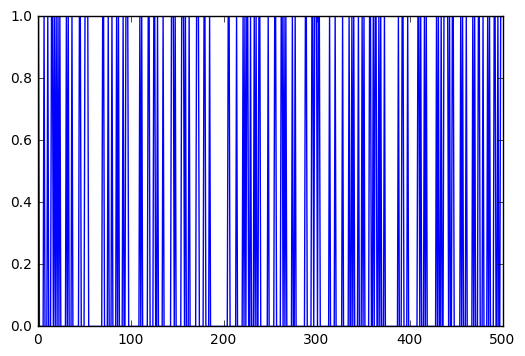

In [215]:
plt.plot(spike_train)

In [216]:
decoded_rate = sum(spike_train)*1/(dt*n_steps)
print decoded_rate

266.0


the 

In [180]:
def compute_prob_of_isi(rate, T):
    prob= rate*np.e**(-rate*T)
    return prob

# Generating a spike train. Method 2

In [3]:
def poisson_spiketrain(n_steps, dt, firing_rate):
    spike_train = np.zeros(n_steps)
    spike_train_rand = np.random.rand(n_steps)
    for i in np.arange(n_steps):
        if spike_train_rand[i] < firing_rate*dt:
            spike_train[i]=1
    return spike_train    

In [220]:
firing_rate=300
spikes = poisson_spiketrain(n_steps, dt, firing_rate)
print(np.shape(np.where(spikes != 0)))
print(spikes[1:20])

(1, 158)
[ 1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.
  0.]


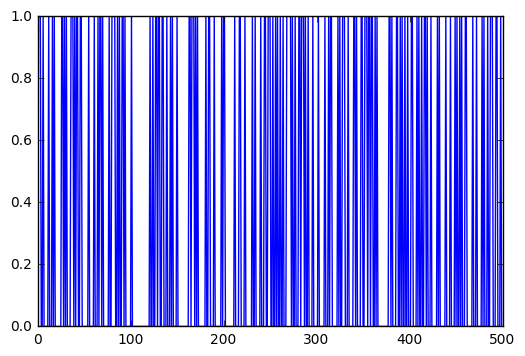

In [221]:
plt.plot(spikes)

In [222]:
decoded_rate = sum(spikes)*1/(dt*n_steps)
print decoded_rate

316.0


Fano factor: F = sigma_n²/E[n]; should be F=1 for a Poisson process

# Filtering for computing the spike rate

## Filtering by convoluting the spike train signal with a rectangular kernel

('scaling factor: ', 100.0)


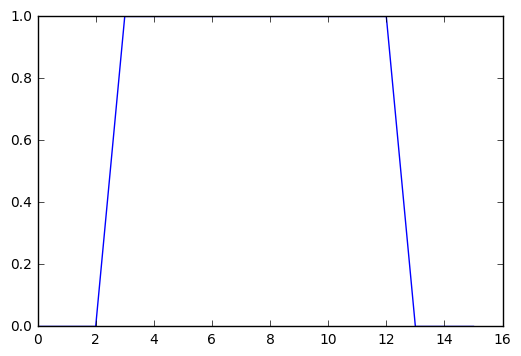

In [255]:
#rect_kernel = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0])
rect_kernel = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0])
plt.plot(rect_kernel)
scaling_factor = 1./np.sum(rect_kernel)*1/dt
print('scaling factor: ',scaling_factor)

In [256]:
def rect_convolution(spikes,rect_kernel,scaling_factor):
    rect_rate = np.convolve(spikes,rect_kernel,mode='same')*scaling_factor
    return rect_rate

In [257]:
rect_rate = rect_convolution(spikes,rect_kernel,scaling_factor)

[ 1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 300.  400.  400.  400.  400.  400.  300.  300.  200.  200.  200.  200.
  200.  300.]
('the mean fire rate is', 314.0)


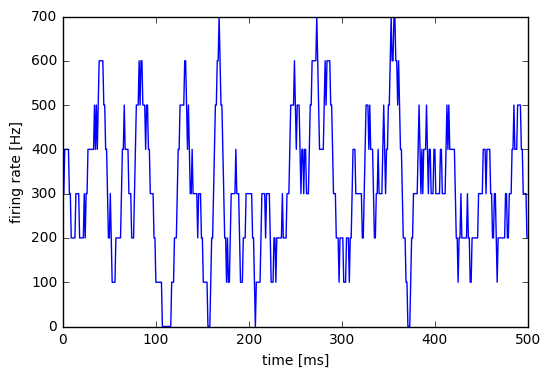

In [258]:
plt.plot(rect_rate)
plt.xlabel('time [ms]')
plt.ylabel('firing rate [Hz]')
print(spikes[1:15])
print(rect_rate[1:15])
mean_fire_rate = np.mean(rect_rate)
print('the mean fire rate is',mean_fire_rate)

The mean firing rate after the filtering is very close to the firing rate which we have set to 300 Hz in the beginning

## Filtering by convoluting the spike train signal with a gaussian kernel

[ 0.05958732  0.104579    0.17242162  0.26705184  0.38855813  0.53109599
  0.68194075  0.82257756  0.93210249  0.99221794  0.99221794  0.93210249
  0.82257756  0.68194075  0.53109599  0.38855813  0.26705184  0.17242162
  0.104579    0.05958732]
('scaling factor: ', 100.96660088760851)


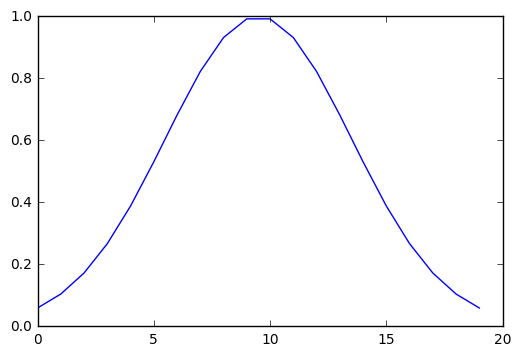

In [60]:
kernel_size = 20 
# the kernel size of the gaussian window depends on the time resolution in which 
# we want to investigate the spike train signal
gaussian_kernel = signal.gaussian(kernel_size, std=4)
print(gaussian_kernel)
plt.plot(gaussian_kernel)
scaling_factor = 1/np.sum(gaussian_kernel)*1/dt
print('scaling factor: ',scaling_factor)

In [233]:
np.sqrt(32*np.pi)
#sum(gaussian_kernel)

10.026513098524001

In [239]:
def gaussian_convolution(spikes,gaussian_kernel,scaling_factor):
    gauss_rate = np.convolve(spikes,gaussian_kernel,mode='same')*scaling_factor
    return gauss_rate

('the mean fire rate is', 310.44504675154235)


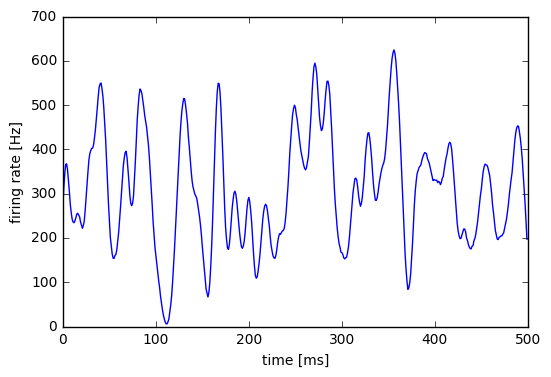

In [240]:
gauss_rate = gaussian_convolution(spikes,gaussian_kernel,scaling_factor)
plt.plot(gauss_rate)
plt.xlabel('time [ms]')
plt.ylabel('firing rate [Hz]')
mean_fire_rate_2 = np.mean(gauss_rate)
print('the mean fire rate is',mean_fire_rate_2)

## Filtering by convoluting the spike train signal with an alpha kernel

In [249]:
f = lambda x: x*0.3*np.exp(2-x*0.3)
alpha_kernel = np.zeros((kernel_size,))
for i in range(kernel_size):
    alpha_kernel[i]=f(i)
    
scaling_factor2 = 1/np.sum(alpha_kernel)*1/dt

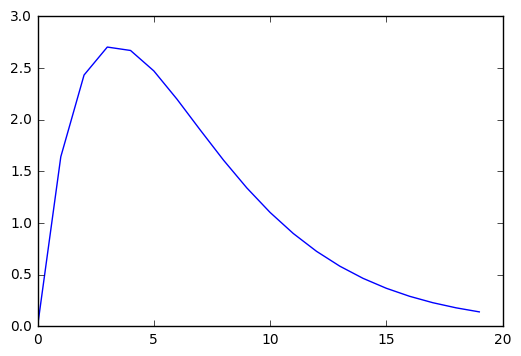

In [250]:
plt.plot(alpha_kernel)

In [243]:
def alpha_convolution(spikes,alpha_kernel,scaling_factor):
    alpha_rate = np.convolve(spikes,alpha_kernel,mode='same')*scaling_factor
    return alpha_rate

('the mean fire rate is', 311.65282394228063)


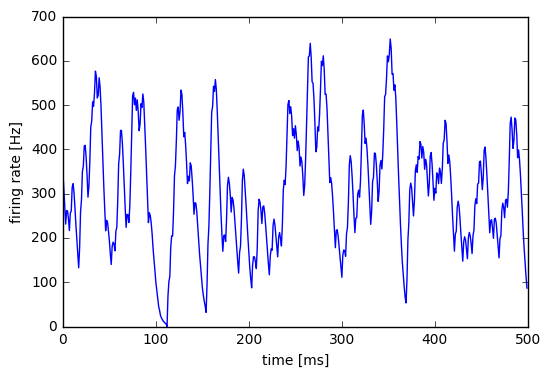

In [244]:
alpha_rate = alpha_convolution(spikes,alpha_kernel,scaling_factor2)
plt.plot(alpha_rate)
plt.xlabel('time [ms]')
plt.ylabel('firing rate [Hz]')
mean_fire_rate_3 = np.mean(alpha_rate)
print('the mean fire rate is',mean_fire_rate_3)